<a href="https://colab.research.google.com/github/ollie3951/ELE2038-Control-H5/blob/main/Python_Notebook_Control_H5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Control H5

This Python notebook was developed jointly by Jakub Glogowski, Jonathan Irwin, Oliver Ross, and David Thompson (Team 6) for controlling the pitch angle of an aircraft.

In [ ]:
!pip install control

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import control as ctrl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 7.1 MB/s eta 0:00:00


# 1. Dynamic System Analysis

The aircraft system dynamics is described by the following set of differential equations (which are linear and already in state space representation). State variables are $\alpha, r, \theta$ and input variable is $\delta$.

$$\dot{\alpha}=-0.31\alpha + 57.4r +0.232\delta,$$

$$\dot{r}=-0.016\alpha-0.425r+0.0203\delta,$$

$$\dot{\theta}=56.7r.$$

The 3 transfer functions describing aircraft system dynamics:

$$G_{\alpha}(s)=\frac{Α(s)}{\Delta(s)},$$

$$G_{r}(s)=\frac{R(s)}{\Delta(s)},$$

$$G_{\theta}(s)=\frac{\Theta(s)}{\Delta(s)}.$$

We assume that the system has zero initial conditions when determining these transfer functions.

For open-loop dynamics, we must take into account the impact of the actuator and sensor. From the question sheet, we know the actuator has transfer function

$$G_{a}(s)=\frac{1}{0.0145s+1},$$

and the sensor has transfer function

$$G_{m}(s)=\frac{e^{-0.0063s}}{0.0021s+1}.$$

The actuator has a single pole at $s=-\frac{1}{0.0145}$, and the sensor has a single pole at $s=-\frac{1}{0.0021}$; both have a negative real part and are therefore stable. Since the open-loop system is the cascade of the actuator, aircraft dynamics, and sensor, provided the transfer function relating to the aircraft dynamics ($G_{\alpha}, G_{r}, G_{\theta}$) has only poles with negative real parts, the open-loop system will be stable.

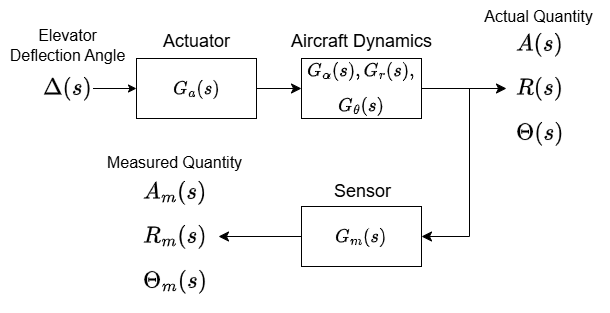

Note the difference between the actual physical quantity ($A, R, \theta$), and the measured quantity ($A_{m}, R_{m}, \theta_{m}$). For each state variable of aircraft dynamics ($\alpha, r, \theta$), we will plot responses for just the measured parameter, although transfer function for the physical parameter is also found.

## Analysis of $G_{\alpha}$ (relating angle of attack $\alpha$ to deflection angle of elevators $\delta$)

In [ ]:
# Defining G_alpha:

s = sym.symbols('s')

num = (57.4*(29*(s+0.425)+145.6525)) / 7175
den = (7175*((s+0.31)*(s+0.425)+0.9184)) / 7175

G_alpha = num / den

G_alpha

(0.232*s + 1.26382)/((s + 0.31)*(s + 0.425) + 0.9184)

Poles of $G_{\alpha}$ occur when $s^{2}+0.735s+1.05015=0$, which can be solved using the quadratic formula to give

$$s=-0.3675 \pm j0.9566.$$

Since the poles have only negative real parts, $G_{\alpha}(s)$ is BIBO stable, meaning the open-loop system relating deflection angle of elevators to angle of attack is also BIBO stable.

Finding transfer function for the actual angle of attack $α$ (not accounting for impact of sensor).

In [ ]:
#defining actuator and sensor transfer functions
G_a = 1 / (0.0145*s + 1) # actuator
G_m = sym.exp(-0.0063 * s) / (0.0021*s + 1)

G_alphaphysical = G_alpha * G_a # transfer function for the actual angle of attack of the system for a given input deflection angle of elevators

G_alphaphysical

(0.232*s + 1.26382)/((0.0145*s + 1)*((s + 0.31)*(s + 0.425) + 0.9184))

Finding $G_{\alpha(\text{open-loop})}$ for the measured angle of attack $α_{m}$ (accounting for impact of sensor).

In [ ]:
G_alphameasured = G_alpha * G_a * G_m # transfer function for the measured angle of attack of the system for a given input deflection angle of elevators

G_alphameasured

(0.232*s + 1.26382)*exp(-0.0063*s)/((0.0021*s + 1)*(0.0145*s + 1)*((s + 0.31)*(s + 0.425) + 0.9184))

Plotting impulse response of $G_{\alpha(\text{open-loop})}$

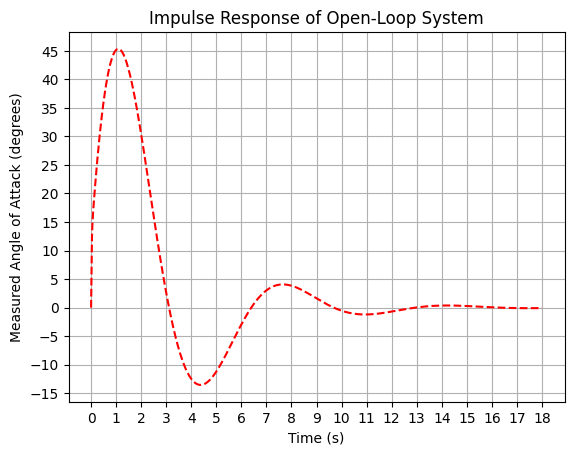

In [61]:
s = ctrl.TransferFunction.s

# times to find impulse response at
ts = np.linspace(0, 18, 1000)

# defining actuator and sensor transfer functions
G_a = 1 / (0.0145*s + 1) # actuator
# ** Generated by Google Colab **
# This approximates the delay using a Padé approximation of order 5
num_delay, den_delay = ctrl.pade(0.0063, 5)  # Padé approximation for delay
# ** End of code generated by Google Colab
G_m = ctrl.TransferFunction(num_delay, den_delay) / (0.0021 * s + 1)

# defining angle of attack transfer function
num = (57.4*(29*(s+0.425)+145.6525)) / 7175
den = (7175*((s+0.31)*(s+0.425)+0.9184)) / 7175
G_alpha = num / den

# defining open-loop transfer function
G_alphaol = G_alpha * G_a * G_m

# getting impulse response of the system (angle of attack a over time t)
t_imp, a_imp = ctrl.impulse_response(G_alphaol, ts)

# plotting impulse response
plt.plot(t_imp, np.rad2deg(a_imp), 'r--', linewidth=1.5)
plt.xlabel('Time (s)')
plt.xticks(np.linspace(0, 18, 19))
plt.ylabel('Measured Angle of Attack (degrees)')
plt.yticks(np.linspace(-15, 45, 13))
plt.title('Impulse Response of Open-Loop System')
plt.grid()
plt.show()

This shows that when the deflection angle of the elevators $\delta$ is a unit impulse, the measured angle of attack $\alpha$ of the aircraft reaches a maximum angle of roughly $45$ degrees at $1$ second, before stabilising at 0 degrees after $16$ seconds.

Plotting step response of $G_{\alpha(\text{open-loop})}$

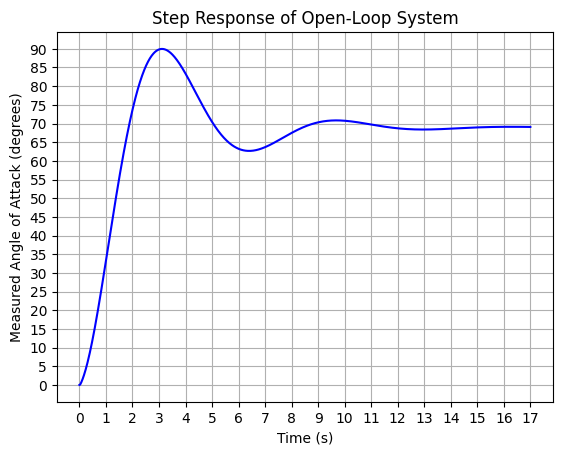

In [ ]:
s = ctrl.TransferFunction.s

# times to find step response at
ts = np.linspace(0, 17, 1000)

# getting step response of the system (angle of attack a over time t)
t_step, a_step = ctrl.step_response(G_alphaol, ts)

# plotting step response
plt.plot(t_step, np.rad2deg(a_step), 'b', linewidth=1.5)
plt.xlabel('Time (s)')
plt.xticks(np.linspace(0, 17, 18))
plt.ylabel('Measured Angle of Attack (degrees)')
plt.title('Step Response of Open-Loop System')
plt.yticks(np.linspace(0, 90, 19))
plt.grid()
plt.show()

This shows that when the deflection angle of the elevators $\delta$ is a unit step, the angle of attack $\alpha$ of the aircraft reaches a maximum angle of roughly 90 degrees after 3 seconds, before stabilising just beneath 70 degrees after 15 seconds.

Plotting frequency response of $G_{\alpha}$.

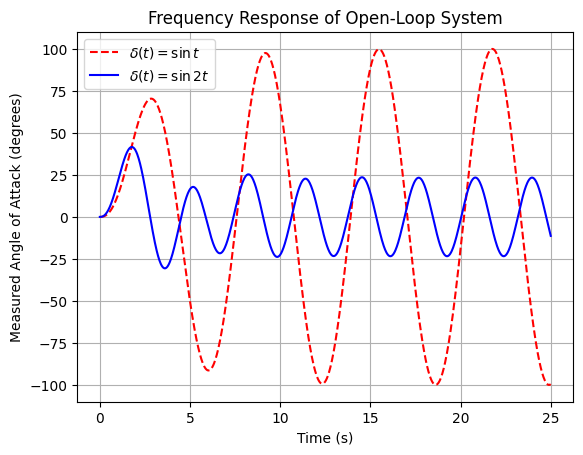

In [60]:
s = ctrl.TransferFunction.s

# times to find frequency response at
ts = np.linspace(0, 25, 1000)

# delta = sin(t)
# defining s domain input for frequency response
Delta = 1 / (s**2 + 1)

# getting frequency response of the system (angle of attack a over time t)
t_freq, a_freq = ctrl.impulse_response(G_alphaol*Delta, ts) # impulse response acts as ILT here

# plotting frequency response
plt.plot(t_freq, np.rad2deg(a_freq), 'r--', linewidth=1.5, label='$\delta(t)=\sin{t}$')

#delta = sin(2t)
# defining s domain input for frequency response
Delta = 2 / (s**2 + 2**2)

# getting frequency response of the system (angle of attack a over time t)
t_freq, a_freq = ctrl.impulse_response(G_alphaol*Delta, ts) # impulse response acts as ILT here

# plotting frequency response
plt.plot(t_freq, np.rad2deg(a_freq), 'b', linewidth=1.5, label='$\delta(t)=\sin{2t}$')

# configuring plot
plt.xlabel('Time (s)')
plt.ylabel('Measured Angle of Attack (degrees)')
plt.title('Frequency Response of Open-Loop System')
plt.grid()
plt.legend()
plt.show()

This shows that when the deflection angle of the elevators $\delta$ is $\sin{t}$, the angle of attack $\alpha$ of the aircraft oscillates with period $2\pi$, and with a maximum of $\alpha \approx 100$ degrees. When the angular frequency is doubled i.e. $\delta(t)=\sin{2t}$, the period of oscillation of the angle of attack halves and the maximum amplitude of the angle of oscillation also decreases to around $25$ degrees.

## Analysis of $G_{r}$ (relating pitch rate $r$ to deflection angle of elevators $\delta$)

In [ ]:
# Finding G_r:

s = sym.symbols('s')

num = -0.003712 + 0.0203 * (s + 0.31)
den = (s + 0.425) * (s + 0.31) + 0.9184

G_r = num / den

G_r

(0.0203*s + 0.002581)/((s + 0.31)*(s + 0.425) + 0.9184)

Poles of $G_{r}$ occur when $s^{2}+0.735s+1.05015=0$, which can be solved using the quadratic formula to give

$$s=-0.3675 \pm j0.9566.$$

Since the poles have only negative real parts, $G_{r}(s)$ is BIBO stable, meaning the open-loop system relating deflection angle of elevators to pitch rate is also BIBO stable.

Finding transfer function for the actual pitch rate $r$ (not accounting for impact of sensor).

In [ ]:
#defining actuator and sensor transfer functions
G_a = 1 / (0.0145*s + 1) # actuator
G_m = sym.exp(-0.0063 * s) / (0.0021*s + 1)

G_rphysical = G_r * G_a # transfer function for the actual pitch rate of the system for a given input deflection angle of elevators

G_rphysical

(0.0203*s + 0.002581)/((0.0145*s + 1)*((s + 0.31)*(s + 0.425) + 0.9184))

Finding $G_{r(\text{open-loop})}$ for the measured pitch rate $r_{m}$ (accounting for impact of sensor).

In [ ]:
G_rmeasured = G_r * G_a * G_m # transfer function for the measured pitch rate of the system for a given input deflection angle of elevators

G_rmeasured

(0.0203*s + 0.002581)*exp(-0.0063*s)/((0.0021*s + 1)*(0.0145*s + 1)*((s + 0.31)*(s + 0.425) + 0.9184))

Plotting impulse response of $G_{r(\text{open-loop})}$

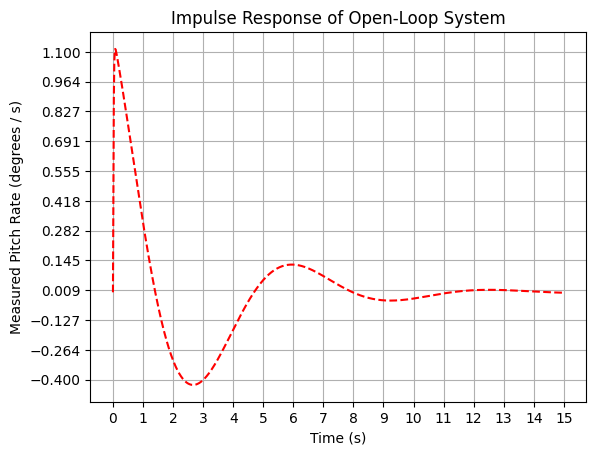

In [59]:
s = ctrl.TransferFunction.s

# times to find impulse response at
ts = np.linspace(0, 15, 1000)

# defining actuator and sensor transfer functions
G_a = 1 / (0.0145*s + 1) # actuator
# ** Generated by Google Colab **
# This approximates the delay using a Padé approximation of order 5
num_delay, den_delay = ctrl.pade(0.0063, 5)  # Padé approximation for delay
# ** End of code generated by Google Colab
G_m = ctrl.TransferFunction(num_delay, den_delay) / (0.0021 * s + 1)

# defining pitch rate transfer function
num = -0.003712 + 0.0203 * (s + 0.31)
den = (s + 0.425) * (s + 0.31) + 0.9184
G_r = num / den

# defining open-loop transfer function
G_rol = G_r * G_a * G_m

# getting impulse response of the system (pitch rate r over time t)
t_imp, r_imp = ctrl.impulse_response(G_rol, ts)

# plotting impulse response
plt.plot(t_imp, np.rad2deg(r_imp), 'r--', linewidth=1.5)
plt.xlabel('Time (s)')
plt.xticks(np.linspace(0, 15, 16))
plt.ylabel('Measured Pitch Rate (degrees / s)')
plt.yticks(np.linspace(-0.4, 1.1, 12))
plt.title('Impulse Response of Open-Loop System')
plt.grid()
plt.show()

This shows that when the deflection angle of the elevators $\delta$ is a unit impulse, the pitch rate $r$ of the aircraft reaches a maximum of roughly 1.1 degrees/s immediately at 0 seconds, before stabilising at (roughly) 0 degrees/s after 11.5 seconds.

Plotting step response of $G_{r(\text{open-loop})}$

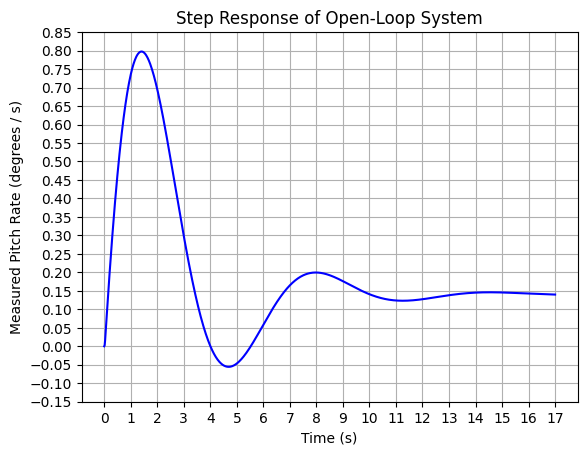

In [ ]:
s = ctrl.TransferFunction.s

# times to find step response at
ts = np.linspace(0, 17, 1000)

# getting step response of the system (pitch rate r over time t)
t_step, r_step = ctrl.step_response(G_rol, ts)

# plotting step response
plt.plot(t_step, np.rad2deg(r_step), 'b', linewidth=1.5)
plt.xlabel('Time (s)')
plt.xticks(np.linspace(0, 17, 18))
plt.ylabel('Measured Pitch Rate (degrees / s)')
plt.yticks(np.linspace(-0.15, 0.85, 21))
plt.title('Step Response of Open-Loop System')
plt.grid()
plt.show()

This shows that when the deflection angle of the elevators $\delta$ is a unit step, the pitch rate $r$ of the aircraft reaches a maximum of roughly 0.8 degrees/s after 1.5 seconds, before stabilising at (roughly) 0.15 degrees/s after 13.5 seconds.

Plotting frequency response of $G_{r}$

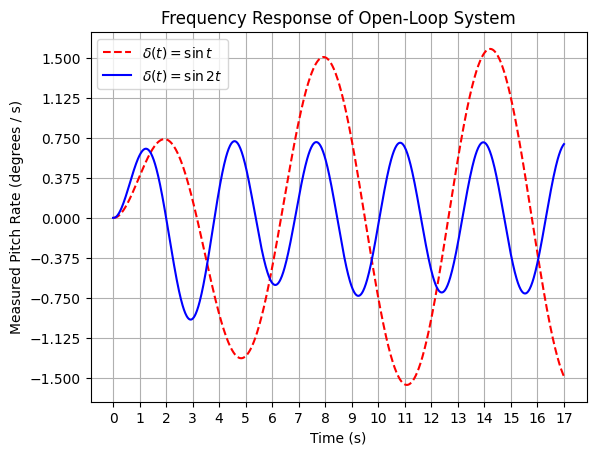

In [58]:
s = ctrl.TransferFunction.s

# times to find frequency response at
ts = np.linspace(0, 17, 1000)

# delta = sin(t)
# defining s domain input for frequency response
Delta = 1 / (s**2 + 1)

# getting frequency response of the system (pitch rate r over time t)
t_freq, r_freq = ctrl.impulse_response(G_rol*Delta, ts) # impulse response acts as ILT here

# plotting frequency response
plt.plot(t_freq, np.rad2deg(r_freq), 'r--', linewidth=1.5, label='$\delta(t)=\sin{t}$')

#delta = sin(2t)
# defining s domain input for frequency response
Delta = 2 / (s**2 + 2**2)

# getting frequency response of the system (pitch rate r over time t)
t_freq, r_freq = ctrl.impulse_response(G_rol*Delta, ts) # impulse response acts as ILT here

# plotting frequency response
plt.plot(t_freq, np.rad2deg(r_freq), 'b', linewidth=1.5, label='$\delta(t)=\sin{2t}$')


plt.xlabel('Time (s)')
plt.xticks(np.linspace(0, 17, 18))
plt.ylabel('Measured Pitch Rate (degrees / s)')
plt.yticks(np.linspace(-1.5, 1.5, 9))
plt.title('Frequency Response of Open-Loop System')
plt.grid()
plt.legend()
plt.show()

This shows that when the deflection angle of the elevators $\delta$ is $\sin{t}$, the pitch rate $r$ of the aircraft oscillates with period $2\pi$, and with a maximum of $r \approx 1.5$ degrees/s. When the angular frequency is doubled i.e. $\delta(t)=\sin{2t}$, the period of oscillation of the pitch rate halves and the maximum amplitude of the oscillation also decreases to around $0.75$ degrees/s.

## Analysis of $G_{\theta}$ (relating pitch angle $\theta$ to deflection angle of elevators $\delta$)

See notes for derivation of $G_{\theta}$ using the system of differential equations.

In [ ]:
# Finding G_theta:

s = sym.symbols('s')

num = 56.7 * (-0.003712 + 0.0203 * (s + 0.31))
den = s * ((s + 0.425) * (s + 0.31) + 0.9184)
G_theta = num / den

G_theta

(1.15101*s + 0.1463427)/(s*((s + 0.31)*(s + 0.425) + 0.9184))

Since $G_{\theta}(s)=\frac{56.7}{s}G_{r}(s)$, $G_{\theta}(s)$ shares all of the poles of $G_{r}(s)$ (which are all stable), but also possesses an additional pole at $s=0$. This means the poles of $G_{\theta}(s)$ are

$$s=-0.3675 \pm j0.9566, \\ s=0.$$

Since we have a pole with a non-negative real part, $G_{\theta}$ is not BIBO stable, meaning the open-loop system relating deflection angle of elevators to pitch angle is also not BIBO stable. This means a controller will be required to obtain BIBO stability of the system.

Finding transfer function for the actual pitch angle $\theta$ (not accounting for impact of sensor).

In [ ]:
#defining actuator and sensor transfer functions
G_a = 1 / (0.0145*s + 1) # actuator
G_m = sym.exp(-0.0063 * s) / (0.0021*s + 1)

G_thetaphysical = G_theta * G_a # transfer function for the actual pitch angle of the system for a given input deflection angle of elevators

G_thetaphysical

(1.15101*s + 0.1463427)/(s*(0.0145*s + 1)*((s + 0.31)*(s + 0.425) + 0.9184))

Finding $G_{\theta(\text{open-loop})}$ for the measured pitch angle $\theta_{m}$ (accounting for impact of sensor).

In [ ]:
G_thetameasured = G_theta * G_a * G_m # transfer function for the measured pitch angle of the system for a given input deflection angle of elevators

G_thetameasured

(1.15101*s + 0.1463427)*exp(-0.0063*s)/(s*(0.0021*s + 1)*(0.0145*s + 1)*((s + 0.31)*(s + 0.425) + 0.9184))

Plotting impulse response of $G_{\theta(\text{open-loop})}$

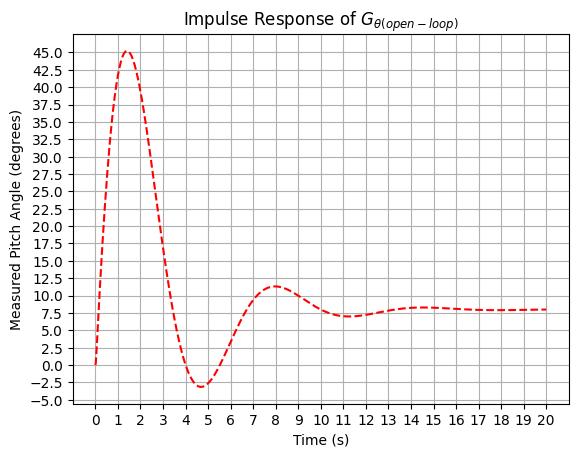

In [70]:
s = ctrl.TransferFunction.s

# times to find impulse response at
ts = np.linspace(0, 20, 1000)

# defining actuator and sensor transfer functions
G_a = 1 / (0.0145*s + 1) # actuator
# ** Generated by Google Colab **
# This approximates the delay using a Padé approximation of order 5
num_delay, den_delay = ctrl.pade(0.0063, 5)  # Padé approximation for delay
# ** End of code generated by Google Colab
G_m = ctrl.TransferFunction(num_delay, den_delay) / (0.0021 * s + 1)

# defining pitch angle transfer function
num = 56.7 * (-0.003712 + 0.0203 * (s + 0.31))
den = s * ((s + 0.425) * (s + 0.31) + 0.9184)
G_theta = num / den

# defining open-loop transfer function
G_thetaol = G_theta * G_a * G_m

# getting impulse response of the system (pitch angle theta over time t)
t_imp, theta_imp = ctrl.impulse_response(G_thetaol, ts)

# plotting impulse response
plt.plot(t_imp, np.rad2deg(theta_imp), 'r--', linewidth=1.5)
plt.xlabel('Time (s)')
plt.xticks(np.linspace(0, 20, 21))
plt.ylabel('Measured Pitch Angle (degrees)')
plt.yticks(np.linspace(-5, 45, 21))
plt.title('Impulse Response of $G_{θ(open-loop)}$')
plt.grid()
plt.show()

This shows that when the deflection angle of the elevators $\delta$ is a unit impulse, the pitch angle $\theta$ of the aircraft reaches a maximum of roughly 45 degrees after 1.5 seconds, before stabilising around 7.5 degrees after around 16 seconds. Note that despite the input being a unit impulse, the pitch angle does not return to zero for the open-loop system.

Plotting step response of $G_{\theta(\text{open-loop})}$

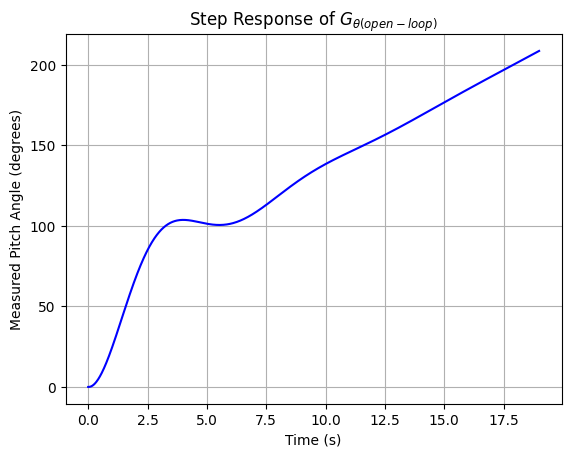

In [71]:
ts = np.linspace(0, 19, 1000)

# getting step response of the system (pitch angle theta over time t)
t_step, theta_step = ctrl.step_response(G_thetaol, ts)

# plotting step response
plt.plot(t_step, np.rad2deg(theta_step), 'b', linewidth=1.5)
plt.xlabel('Time (s)')
plt.ylabel('Measured Pitch Angle (degrees)')
plt.title('Step Response of $G_{θ(open-loop)}$')
plt.grid()
plt.show()

As time increases, pitch angle $\theta$ is increasing unbounded. This follows from the prior descovery that $G_{\theta(\text{open-loop})}$ is not BIBO stable.

Plotting frequency response of $G_{\theta(\text{open-loop})}$

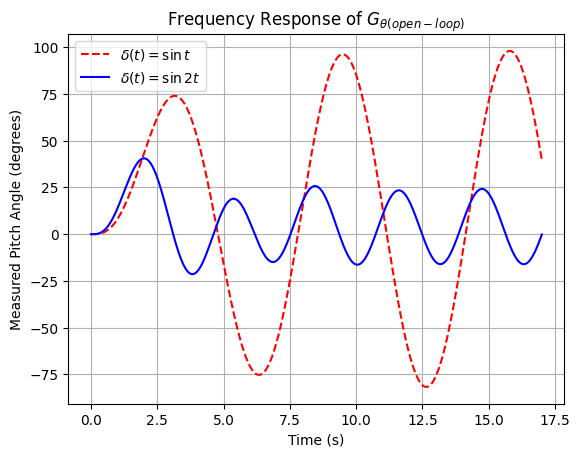

In [72]:
s = ctrl.TransferFunction.s

# times to find frequency response at
ts = np.linspace(0, 17, 1000)

# delta = sin(t)
# defining s domain input for frequency response
Delta = 1 / (s**2 + 1)

# getting frequency response of the system (pitch angle theta over time t)
t_freq, theta_freq = ctrl.impulse_response(G_thetaol*Delta, ts) # impulse response acts as ILT here

# plotting frequency response
plt.plot(t_freq, np.rad2deg(theta_freq), 'r--', linewidth=1.5, label='$\delta(t)=\sin{t}$')

#delta = sin(2t)
# defining s domain input for frequency response
Delta = 2 / (s**2 + 2**2)

# getting frequency response of the system (pitch rate r over time t)
t_freq, theta_freq = ctrl.impulse_response(G_thetaol*Delta, ts) # impulse response acts as ILT here

# plotting frequency response
plt.plot(t_freq, np.rad2deg(theta_freq), 'b', linewidth=1.5, label='$\delta(t)=\sin{2t}$')

plt.xlabel('Time (s)')
plt.ylabel('Measured Pitch Angle (degrees)')
plt.title('Frequency Response of $G_{θ(open-loop)}$')
plt.grid()
plt.legend()
plt.show()

# 2. Controller Design

A PID controller has been used to control the aircraft pitch angle. The I term is required to remove the pole at $s=0$ and to give the system zero offset from the setpoint (which is the deflection angle of the elevators $\delta$). The D term is required to dampen oscilations, which we deemed necessary as an aircraft requires precise control with small overshoot and settling time, and with better stability margins and robustness against disturbances (the aircraft is likely to be exposed to significant disturbances such as strong gusts of wind).

The closed-loop block diagram is given below. The disturbance is modelled on the output, since wind is more likely to affect the pitch angle than the command for the deflection angle of the elevators, which is likely controlled within the aircraft.

Symbolic Expression of the Closed-Loop Transfer Function

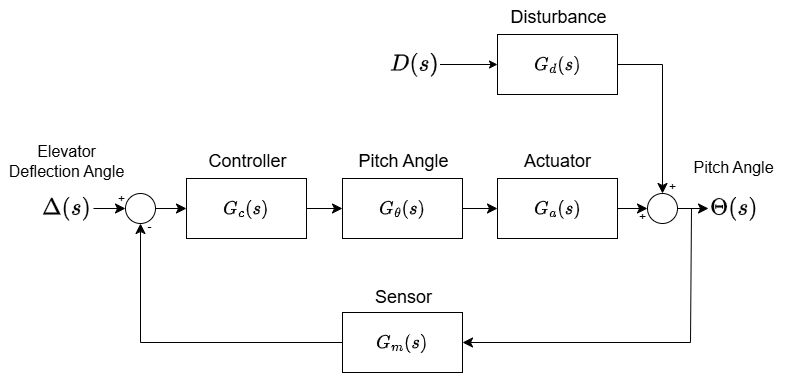

In [ ]:
kc, tau_d, tau_i = sym.symbols('Kc, tau_D, tau_I', real=True)
s = sym.symbols('s')

#defining required transfer functions
G_c = kc * (1 + tau_d * s + 1 / (tau_i * s)) # controller
G_a = 1 / (0.0145 * s + 1) # actuator
G_m = sym.exp(-0.0063 * s) / (0.0021*s + 1)
num = 56.7 * (-0.003712 + 0.0203 * (s + 0.31))
den = s * ((s + 0.425) * (s + 0.31) + 0.9184)
G_theta = num / den # pitch angle

# calculating closed loop transfer function
G_cl = (G_c * G_a * G_theta) / (1 + G_c * G_a * G_theta * G_m)

G_cl.simplify()


Kc*(0.0021*s + 1)*(1.15101*s + 0.1463427)*(s*tau_I*(s*tau_D + 1) + 1)*exp(0.0063*s)/(Kc*(1.15101*s + 0.1463427)*(s*tau_I*(s*tau_D + 1) + 1) + s**2*tau_I*(0.0021*s + 1)*(0.0145*s + 1)*((s + 0.31)*(s + 0.425) + 0.9184)*exp(0.0063*s))

## Analysis of Closed-Loop Transfer Function (Using Control Library)

Defining closed-loop transfer function

In [ ]:
s = ctrl.TransferFunction.s

# system
num = 56.7 * (-0.003712 + 0.0203 * (s + 0.31))
den = s * ((s + 0.425) * (s + 0.31) + 0.9184)
G_theta = num / den
# controller
# PID, for use after tuning
# kc, tau_d, tau_i = 1, 1, 1
# G_c = kc * (1 + tau_d * s + 1 / (tau_i * s))
# initially just use P controller to tune using ZNUS
kc = 23.38
G_c = kc
# actuator
G_a = 1 / (0.0145 * s + 1)
# sensor
# This approximates the delay using a Padé approximation of order 2
num_delay, den_delay = ctrl.pade(0.0063, 2)  # Padé approximation for delay
G_m = ctrl.TransferFunction(num_delay, den_delay) / (0.0021 * s + 1)

# closed-loop transfer function
G_cl = ctrl.feedback(ctrl.series(G_c, G_theta, G_a), G_m)

poles = ctrl.poles(G_cl)
print(f"Closed-loop poles: ")
for p in poles:
    print(f"{p.real:.5f} {'+ ' if p.imag >= 0 else '- '}{abs(p.imag):.2f}j")

print("Closed-loop transfer function:")
G_cl

Closed-loop poles: 
-476.20854 + 274.89j
-476.20854 - 274.89j
-476.06583 + 0.00j
-69.66620 + 0.00j
-0.00006 + 5.25j
-0.00006 - 5.25j
-0.12271 + 0.00j
Closed-loop transfer function:


TransferFunction(array([5.65122890e-02, 8.07390265e+01, 4.27255245e+04, 8.14167094e+06,
       1.03446480e+06]), array([3.04500000e-05, 4.56223808e-02, 2.60494210e+01, 5.99044695e+03,
       3.06786280e+05, 2.02867225e+05, 8.45048710e+06, 1.03446480e+06]))

### ZNUS Tuning

Tuning using Ziegler-Nichols ultimate sensitivity method (note, this targets only the regulation problem, so further adjustment of parameters may be required to address disturbance rejection)

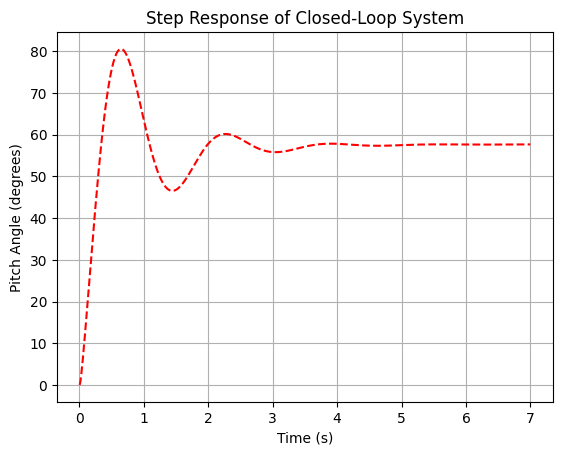

In [55]:
# plotting the step response of the closed loop system

ts = np.linspace(0, 7, 1000)

# getting step response of the system
t_step, CL_step = ctrl.step_response(G_cl, ts)

# plotting step response
plt.plot(t_step, np.rad2deg(CL_step), 'r--', linewidth=1.5)
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (degrees)')
plt.title('Step Response of Closed-Loop System')
plt.grid()
plt.show()

From this, we know that ultimate gain is $K_{u}=23.38$. The ultimate period can be calculated from the graph as:

In [ ]:
# Finding Tu from the above plot

from scipy.signal import find_peaks

Ku = kc # set the ultimate gain

# The code below which calculates the ultimate period has been generated using DeepSeek
# Find peaks in the step response using scipy.signal.find_peaks
peaks, _ = find_peaks(CL_step, height=0)  # Detect peaks
Tu = t_step[peaks[5]] - t_step[peaks[4]]  # Period between peaks

print(f"Ultimate Gain (Ku): {Ku}")
print(f"Ultimate Period (Tu): {Tu:.4f} s")

Ultimate Gain (Ku): 23.38
Ultimate Period (Tu): 1.1982 s


Now that we know the ultimate gain and period, we can calculate values for the PID parameters tuned using ZNUS

In [ ]:
kc = 0.6 * Ku
tau_d = Tu / 8
tau_i = Tu / 2

print(f"Kc: {kc}")
print(f"tau_d: {tau_d}")
print(f"tau_i: {tau_i}")

Kc: 14.027999999999999
tau_d: 0.14977477477477474
tau_i: 0.599099099099099


Testing the closed-loop system with these PID parameters

In [ ]:
# redefining controller transfer function with newly tuned parameters
G_c = kc * (1 + tau_d * s + 1 / (tau_i * s))

# recalculating closed-loop transfer function
G_cl = ctrl.feedback(ctrl.series(G_c, G_theta, G_a), G_m)

poles = ctrl.poles(G_cl)
print(f"Closed-loop poles: ")
for p in poles:
    print(f"{p.real:.2f} {'+ ' if p.imag >= 0 else '- '}{abs(p.imag):.2f}j")

print("Closed-loop transfer function:")
G_cl

Closed-loop poles: 
-474.54 + 276.06j
-474.54 - 276.06j
-481.38 + 0.00j
-64.90 + 0.00j
-0.49 + 3.92j
-0.49 - 3.92j
-1.81 + 0.00j
-0.13 + 0.00j
Closed-loop transfer function:


TransferFunction(array([3.04250633e-03, 4.36713832e+00, 2.32931137e+03, 4.53737488e+05,
       3.00792942e+06, 5.25685072e+06, 6.20678880e+05]), array([1.82425676e-05, 2.73323272e-02, 1.56061846e+01, 3.59032019e+03,
       1.82409298e+05, 5.65557786e+05, 3.15401250e+06, 5.25163702e+06,
       6.20678880e+05]))

All poles have negative real parts, meaning the system is now BIBO stable

####Impulse response

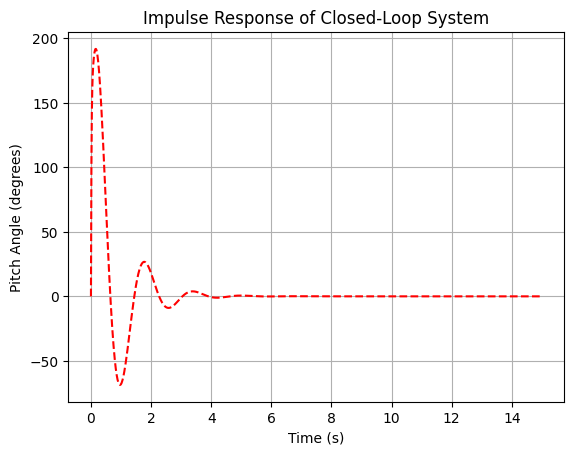

In [54]:
ts = np.linspace(0, 15, 1000)

# getting impulse response of the closed-loop system
t_imp, CL_imp = ctrl.impulse_response(G_cl, ts)

# plotting impulse response
plt.plot(t_imp, np.rad2deg(CL_imp), 'r--', linewidth=1.5)
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (degrees)')
plt.title('Impulse Response of Closed-Loop System')
plt.grid()
plt.show()

####Step response

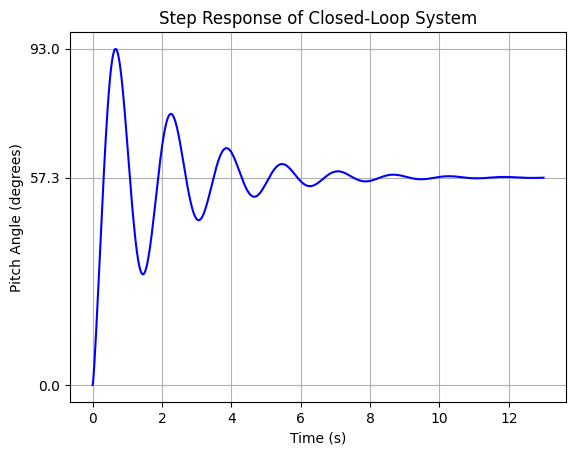

In [ ]:
ts = np.linspace(0, 13, 1000)

# getting step response of the system
t_step, CL_step = ctrl.step_response(G_cl, ts)

# plotting step response
plt.plot(t_step, np.rad2deg(CL_step), 'b', linewidth=1.5)
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (degrees)')
plt.yticks((0, 57.3, 93))
plt.title('Step Response of Closed-Loop System')
plt.grid()
plt.show()

In [ ]:
# Compute step response information
info = ctrl.step_info(G_cl)

# Print rise time, settling time, and overshoot
print(f"Rise Time : {info['RiseTime']:.4f} sec")
print(f"Settling Time : {info['SettlingTime']:.4f} sec")
print(f"Overshoot : {info['Overshoot']:.2f} %")

Rise Time : 0.2363 sec
Settling Time : 7.3076 sec
Overshoot : 62.17 %


Note these controller metrics as they will be improved by manual tuning in the 'Further Tuning' section

For the step response, $$\Delta(s)=\frac{1}{s}$$ so $$\Theta(s)=G_{\text{cl}}(s)Δ(s)=\frac{G_{\text{cl}}}{s}.$$ This means $\Delta(s)$ shares all poles of $G_{\text{cl}}(s)$; which all have negative real parts, along with one additional pole at $s=0$. Below also shows that $\Theta(s)$ is a rational function, therefore the final value theorem may be applied to find $\theta(\infty)$:
$$\theta(\infty)=\lim_{s \to 0^{+}}\left(s\frac{G_{\text{cl}}}{s}\right)=\lim_{s \to 0^{+}}\left(G_{\text{cl}}\right)$$

In [ ]:
Theta = G_cl / s

Theta

TransferFunction(array([3.04250633e-03, 4.36713832e+00, 2.32931137e+03, 4.53737488e+05,
       3.00792942e+06, 5.25685072e+06, 6.20678880e+05]), array([1.82425676e-05, 2.73323272e-02, 1.56061846e+01, 3.59032019e+03,
       1.82409298e+05, 5.65557786e+05, 3.15401250e+06, 5.25163702e+06,
       6.20678880e+05, 0.00000000e+00]))

In [ ]:
G_cl0 = ctrl.dcgain(G_cl)

print(G_cl0)

1.0


Hence $\theta(\infty)=1$, meaning

$$\text{offset} = 1 - \lim_{t \to \infty}\theta(t)=1-1=0.$$

This controller gives zero offset.

####Frequency response

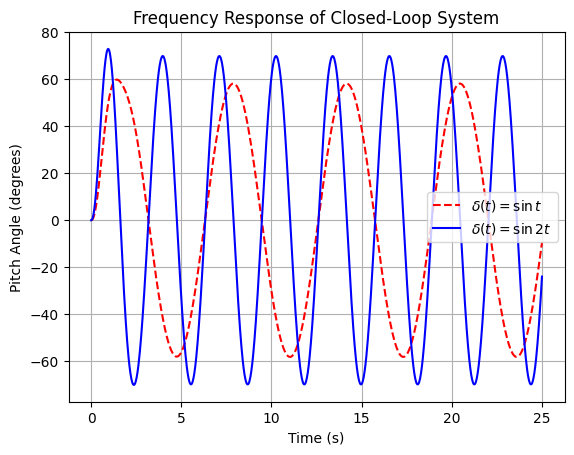

In [53]:
# times to find frequency response at
ts = np.linspace(0, 25, 1000)

# delta = sin(t)
# defining s domain input for frequency response
Delta = 1 / (s**2 + 1)

# getting frequency response of the system (pitch angle theta over time t)
t_freq, CL_freq = ctrl.impulse_response(G_cl*Delta, ts) # impulse response acts as ILT here

# plotting frequency response
plt.plot(t_freq, np.rad2deg(CL_freq), 'r--', linewidth=1.5, label='$\delta(t)=\sin{t}$')

#delta = sin(2t)
# defining s domain input for frequency response
Delta = 2 / (s**2 + 2**2)

# getting frequency response of the system (pitch rate r over time t)
t_freq, CL_freq = ctrl.impulse_response(G_cl*Delta, ts) # impulse response acts as ILT here

# plotting frequency response
plt.plot(t_freq, np.rad2deg(CL_freq), 'b', linewidth=1.5, label='$\delta(t)=\sin{2t}$')


plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (degrees)')
plt.title('Frequency Response of Closed-Loop System')
plt.grid()
plt.legend()
plt.show()

Comparing this frequency response with the open-loop pitch angle frequency response, we can see that the pitch angle follows the set point much more accurately for the closed-loop system than for the open-loop system.

## Further Tuning

Ideally, we want less oscillatory behaviour, and faster convergence to the set point for an aircraft pitch controller. With this in mind, and also avoiding overly aggressive responses, the PID parameters obtained from ZNUS will be manually adjusted in this section.

In [ ]:
Kc = 14.027999999999999 # unchanged from ZNUS
tau_d = 0.16 # Increased from ZNUS by 0.01
tau_i = 2 # Increased from ZNUS by 1.4

# redefining controller transfer function with newly tuned parameters
G_c = kc * (1 + tau_d * s + 1 / (tau_i * s))

# recalculating closed-loop transfer function
G_cl = ctrl.feedback(ctrl.series(G_c, G_theta, G_a), G_m)

poles = ctrl.poles(G_cl)
print(f"Closed-loop poles: ")
for p in poles:
    print(f"{p.real:.2f} {'+ ' if p.imag >= 0 else '- '}{abs(p.imag):.2f}j")

print("Closed-loop transfer function:")
G_cl

Closed-loop poles: 
-474.42 + 276.14j
-474.42 - 276.14j
-481.73 + 0.00j
-64.59 + 0.00j
-1.23 + 3.89j
-1.23 - 3.89j
-0.50 + 0.00j
-0.13 + 0.00j
Closed-loop transfer function:


TransferFunction(array([1.08503595e-02, 1.55697078e+01, 8.30022144e+03, 1.61451989e+06,
       9.99425768e+06, 6.12636032e+06, 6.20678880e+05]), array([6.09000000e-05, 9.12447615e-02, 5.20988420e+01, 1.19860607e+04,
       6.08630890e+05, 1.98778362e+06, 1.05778309e+07, 6.12114662e+06,
       6.20678880e+05]))

The poles remain stable with these manually tuned values. Plotted below is the impulse and step response of the closed-loop system when controlled with this new PID controller.

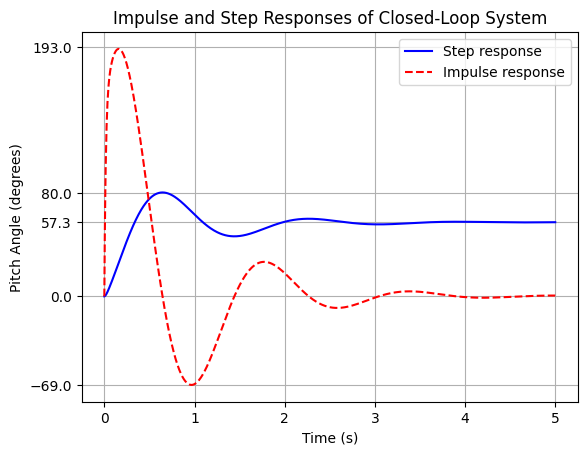

In [52]:
ts = np.linspace(0, 5, 1000)

# getting step response of the system
t_step, CL_step = ctrl.step_response(G_cl, ts)

# plotting step response
plt.plot(t_step, np.rad2deg(CL_step), 'b', linewidth=1.5, label='Step response')

# getting impulse response of the closed-loop system
t_imp, CL_imp = ctrl.impulse_response(G_cl, ts)

# plotting impulse response
plt.plot(t_imp, np.rad2deg(CL_imp), 'r--', linewidth=1.5, label='Impulse response')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (degrees)')
plt.yticks((-69, 0, 57.3, 80, 193))
plt.title('Impulse and Step Responses of Closed-Loop System')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Compute step response information
info = ctrl.step_info(G_cl)

# Print rise time, settling time, and overshoot
print(f"Rise Time (t_r): {info['RiseTime']:.4f} sec")
print(f"Settling Time (t_s): {info['SettlingTime']:.4f} sec")
print(f"Overshoot (M_p): {info['Overshoot']:.2f} %")

Rise Time (t_r): 0.2554 sec
Settling Time (t_s): 3.2456 sec
Overshoot (M_p): 40.59 %


By increasing $\tau_{I}$ and $\tau_{D}$, we were able to reduce the overshoot of the system from 62.17% (for ZNUS method) to 40.59% (for this controller), and reduce the settling time from 7.3 seconds (for ZNUS method) to 3.2 seconds (for this controller), making this manually tuned controller more appropriate for aircraft pitch control than the one tuned using ZNUS. The rise time is slightly increased (since overshoot reduction has been prioritised over rise time reduction), although at just a quarter of a second it is likely fast enough for aircraft pitch control.

In [ ]:
G_cl0 = ctrl.dcgain(G_cl)

print(G_cl0)

1.0


Therefore offset remains the same,

$$\text{offset}=0.$$

Checking impact on frequency response

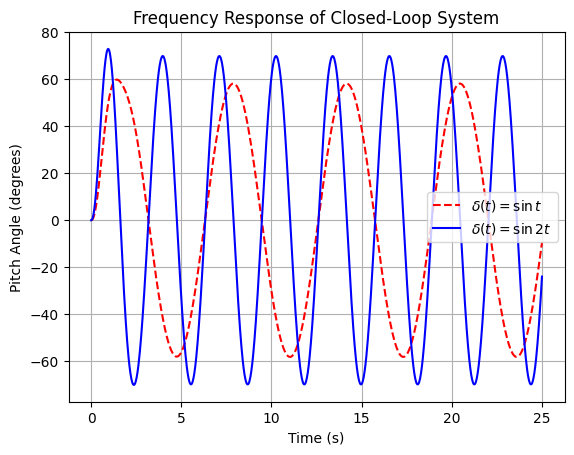

In [51]:
# times to find frequency response at
ts = np.linspace(0, 25, 1000)

# delta = sin(t)
# defining s domain input for frequency response
Delta = 1 / (s**2 + 1)

# getting frequency response of the system (pitch angle theta over time t)
t_freq, CL_freq = ctrl.impulse_response(G_cl*Delta, ts) # impulse response acts as ILT here

# plotting frequency response
plt.plot(t_freq, np.rad2deg(CL_freq), 'r--', linewidth=1.5, label='$\delta(t)=\sin{t}$')

#delta = sin(2t)
# defining s domain input for frequency response
Delta = 2 / (s**2 + 2**2)

# getting frequency response of the system (pitch rate r over time t)
t_freq, CL_freq = ctrl.impulse_response(G_cl*Delta, ts) # impulse response acts as ILT here

# plotting frequency response
plt.plot(t_freq, np.rad2deg(CL_freq), 'b', linewidth=1.5, label='$\delta(t)=\sin{2t}$')


plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (degrees)')
plt.title('Frequency Response of Closed-Loop System')
plt.grid()
plt.legend()
plt.show()

Frequency response is broadly the same for both controllers.

### Bode Stability Criterion to Check BIBO Stability of Closed-Loop System

Now that we have our controller, we can test its stability using the Bode Plot Stability Criterion. There are three conditions for stability according to the criterion:
<ol>
<li>$G_{ol}$ has no poles on or to the right of the imaginary axis, with the exception of a single pole at the origin </li>
<li>The open-loop system has $k$-th order phase crossover frequencies $ω_{co,k}$ for some  $k ∈ \mathbb{N}$</li>
<li>$|G_{\text{ol}}(jω_{co,k})| < 1$ for all $k$-th order phase crossover frequencies $ω_{co,k}$ </li>
</ol>

Then the closed loop system is BIBO-stable

The poles of the open-loop system are

In [ ]:
poles = ctrl.poles(G_thetaol)
print(f"Open-loop poles: ")
for p in poles:
    print(f"{p.real:.2f} {'+ ' if p.imag >= 0 else '- '}{abs(p.imag):.2f}j")

Open-loop poles: 
-737.99 + 1133.66j
-737.99 - 1133.66j
-1064.11 + 553.23j
-1064.11 - 553.23j
-1157.69 + 0.00j
-476.19 + 0.00j
-68.97 + 0.00j
-0.37 + 0.96j
-0.37 - 0.96j
0.00 + 0.00j


All poles of the open-loop transfer function have a negative real part, except for a single pole at $s=0$, satisfying criteria 1 of Bode stability criterion.

Checking phase crossover frequencies of the open-loop system by plotting the Bode plot. A phase crossover frequency $\omega_{\text{co}}$ is where $\arg{G_{\text{open-loop}}(jω_{\text{co}})}=-\pi$. A $k$th order phase crossover frequency $\omega_{\text{co,k}}$, for $k=1, 2, 3, …$, is where $\arg{G_{\text{open-loop}}(jω_{\text{co}})}=-\pi-2k\pi$.

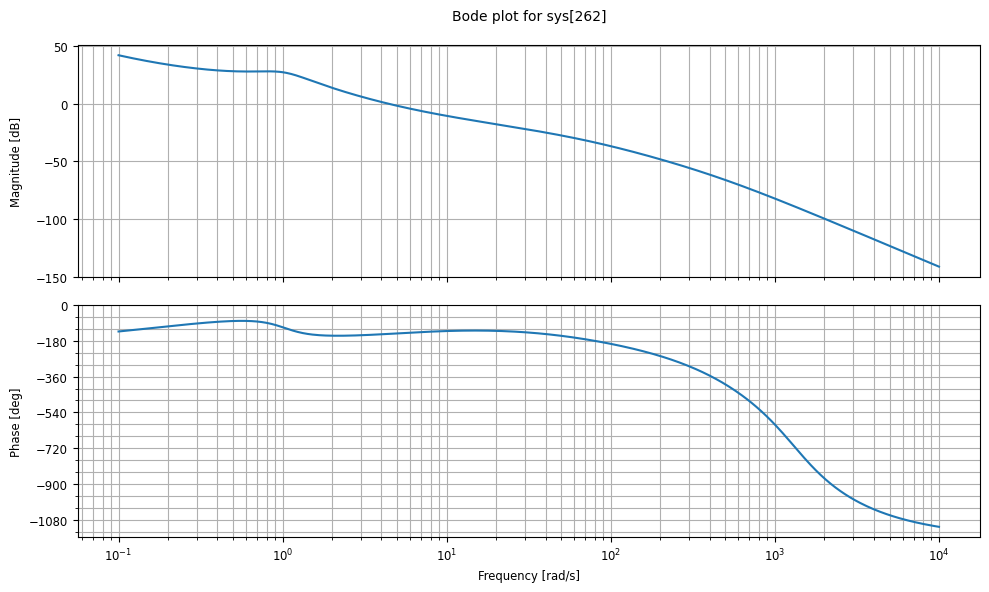

In [ ]:
omegas = np.logspace(-1, 4, 500)

plt.figure(figsize=(10, 6))
ctrl.bode(G_thetaol * G_c, omegas, dB = True)
plt.show()

(Due to use of Pade approximation, the accuracy of this Bode plot declines at high frequencies. A more accurate Bode plot is given in the follwing section on stability margins)

From the Bode plot, we can see that crossover frequencies occur at $\omega_{\text{co,0}}=63, \; \; \omega_{\text{co,1}} = 630, \; \; \omega_{\text{co,2}} = 1412$. Since the open-loop system has phase crossover frequencies, criteria 2 of the Bode stability criterion is satisfied.

From inspection of the graph, we can see that $|G_{\text{ol}}(jω_{co,k})| < 1$ is satisfied, therefore criteria 3 is also satisfied, therefore the closed-loop system is BIBO stable.

### Checking Stability Margins - how stable is our closed-loop system?

1. (Gain margin) How much of a gain can we introduce to the closed loop before the stabilising conditions of the Bode stability criterion cease to hold

2. How much of a time delay?

In [76]:
def plot_bode_with_delay(G_no_delay,
                         delay,
                         log_omega_min=-1,
                         log_omega_max=-1,
                         n_omegas=250,
                         colour='k'):
    """
    Plot the Bode plot of a transfer function with a time delay.

    Arguments:
    @param G_no_delay: The transfer function without a time delay.
    @param delay: The time delay.
    @param log_omega_min: The minimum logarithm of the frequency.
    @param log_omega_max: The maximum logarithm of the frequency.
    @param n_omegas: The number of frequencies to plot.
    @param colour: Line colour.
    """
    omega_min, omega_max = 10**log_omega_min, 10**log_omega_max
    omegas = np.logspace(
        log_omega_min,
        log_omega_max,
        n_omegas
        )
    m, p, _ = ctrl.bode(
        G_no_delay,
        omegas,
        plot=False
        )
    phase_with_delay_degrees = np.rad2deg(p - delay*omegas)

    n = phase_with_delay_degrees.shape[0]
    for i in range(n):
        if phase_with_delay_degrees[i] < -180:
            break
    omega_crossover = omegas[i]
    gain_at_omega_crossover = m[i]

    plt.subplot(211)
    plt.loglog(
        omegas,
        m,
        colour,
        linewidth=2
        )
    # plt.loglog([omega_crossover, omega_crossover],
    #     [np.min(m), np.max(m)],
    #     'g--',
    #     linewidth=1
    #     )
    # plt.loglog([omega_min, omega_max],
    #     [gain_at_omega_crossover, gain_at_omega_crossover],
    #     'p--',
    #     linewidth=1
    #     )
    plt.xlim([omega_min, omega_max])
    plt.ylabel('Magnitude')
    plt.title('Open-Loop Bode Plots')
    plt.figsize=(10, 6)
    plot_bode_with_delay
    plt.grid(True, which='minor')

    plt.subplot(212)
    plt.grid(True)
    plt.semilogx(
        omegas,
        phase_with_delay_degrees,
        colour,
        linewidth=2
        )
    # plt.semilogx(
    #     omegas,
    #     -180 + 0*omegas,
    #     'g--',
    #     linewidth=1
    #     )
    # plt.semilogx(
    #     [omega_crossover, omega_crossover],
    #     [np.min(phase_with_delay_degrees), np.max(phase_with_delay_degrees)],
    #     'p--',
    #     linewidth=1
    #     )
    plot_bode_with_delay
    plt.ylabel('Phase (deg)')
    plt.xlabel('Frequency')
    plt.grid(True, which='minor')

####1. Gain margin

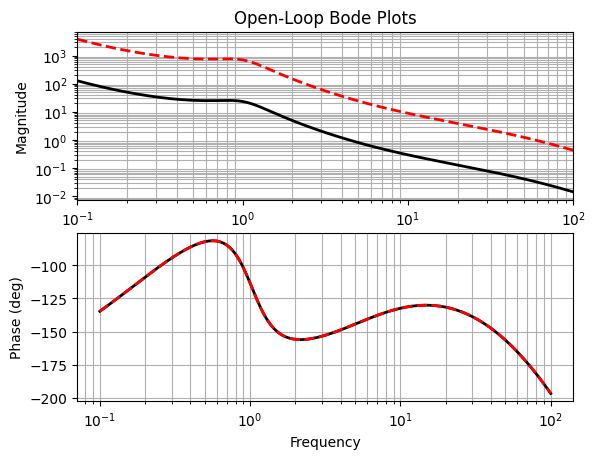

In [77]:
# defining open-loop transfer function WITHOUT DELAY OF SENSOR
Gol = G_c * G_theta * G_a * (1 / (0.0021 * s + 1))
delay = 0.0063

# plotting system with unity gain first
plot_bode_with_delay(Gol, delay, -1, 2., colour='k')

# adding gain to test max gain while Bode stability criterion still holds
gain = 30
G_ol_gain = gain * Gol

# plotting on same graph
plot_bode_with_delay(G_ol_gain, delay, -1, 2., colour='r--')
plt.show()

Criteria 3 of the Bode stability criterion is violated when a gain $K>30$ is introduced to the system. This means the gain margin of our system is $29.5$ dB. This infers our system is very stable.

####2. Delay margin

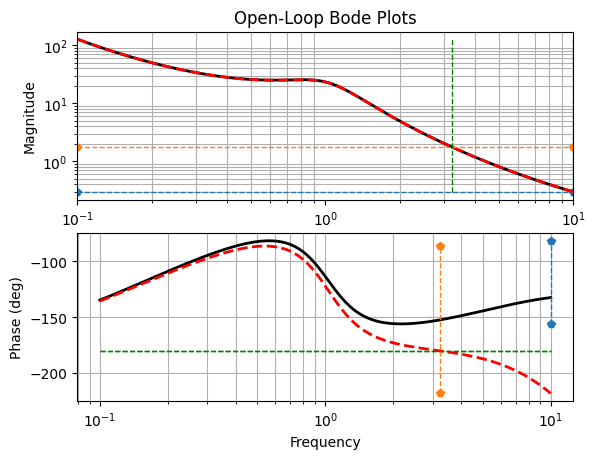

In [75]:
# plotting system with no additional delay first
plot_bode_with_delay(Gol, delay, -1, 1., colour='k')

# adding delay to test max delay while Bode stability criterion still holds
plot_bode_with_delay(Gol, delay+0.15, -1, 1., colour='r--')
plt.show()

Criteria 3 of the Bode stability criterion is violated when a time delay $D>0.15$ is introduced to the system. This means the delay margin DM of our system is $0.15$ seconds. This indicates the system has adequate stability when faced with small time delays, although a larger delay margin would be favourable to make the system more stable.

From the Bode plot, $|G_{\rm ol}(j2.51)|=1$, therefore $\omega_{g}=2.51$, and phase margin PM can be determined

$$\text{PM}= \omega_{g}\text{DM}=(2.51)(0.15)=0.38 \; \text{rad} = 21.6 \; \text{degrees}.$$

This is a relatively low phase margin, although may be adequate if the system is subjected to only small delays.

### Disturbance Rejection

Possible disturbances include wind gusts (modelled as a unit step input) and turbulence (modelled as a unit impulse)

If we assume $\Delta(s)=0$, then using the closed-loop block diagram given at the start of this section,

$$G_{L}(s)=\frac{G_{d}}{1+G_{c}G_{a}G_{\theta}G_{m}}.$$

We are going to let $G_d = \frac{K}{\tau s + 1}$ where $K$ and $τ$ are values that we will adjust in our code (first-order with static gain $K$ and time constant $\tau$).

In [ ]:
K = 1
tau = 1

G_d = K/(tau*s + 1)

G_L = G_d / 1 + G_a * G_c * G_m * G_theta
G_L

TransferFunction(array([6.09000000e-05, 9.12447615e-02, 5.72656798e+01, 7.09821246e+03,
       2.13942859e+06, 1.19306031e+07, 1.66989775e+07, 6.74182550e+06,
       6.20678880e+05]), array([6.09000000e-05, 9.13056615e-02, 5.21900867e+01, 1.20329927e+04,
       6.25499632e+05, 1.07050466e+06, 1.09199726e+06, 6.35011338e+05,
       0.00000000e+00, 0.00000000e+00]))

Checking BIBO stability of $G_{L}(s)$

In [ ]:
poles = ctrl.poles(G_L)
print(f"Poles: ")
for p in poles:
    print(f"{p.real:.2f} {'+ ' if p.imag >= 0 else '- '}{abs(p.imag):.2f}j")

Poles: 
-476.19 + 274.93j
-476.19 - 274.93j
-476.19 + 0.00j
-68.97 + 0.00j
-1.00 + 0.00j
-0.37 + 0.96j
-0.37 - 0.96j
0.00 + 0.00j
0.00 + 0.00j


We have two poles at $s=0$, which means the load transfer function is not BIBO stable. This means that after a bounded disturbance, the output pitch angle does not currently return to its equilibrium value, $\Theta(s)=0$.

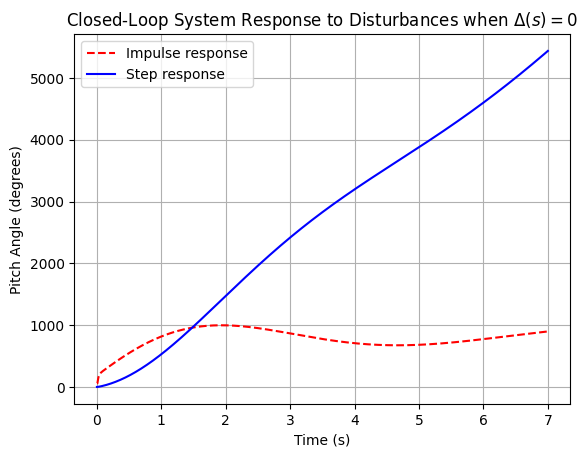

In [50]:
ts = np.linspace(0, 7, 1000)

#Plot the impulse response
td_imp, thetad_imp = ctrl.impulse_response(G_L, ts)
plt.plot(td_imp, np.rad2deg(thetad_imp), 'r--', linewidth=1.5, label='Impulse response')


#Plot the step response
td_step, thetad_step = ctrl.step_response(G_L, ts)
plt.plot(td_step, np.rad2deg(thetad_step), 'b', linewidth=1.5, label='Step response')

plt.title('Closed-Loop System Response to Disturbances when $\Delta(s)=0$')
plt.ylabel('Pitch Angle (degrees)')
plt.xlabel('Time (s)')
plt.grid()
plt.legend()
plt.show()

As expected from the poles, the response of the closed-loop system to disturbances is unstable. The controller that we have designed has poor disturbance rejection.